# Mounting drive



In [1]:
from google.colab import drive
from sys import path

drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/nlp-lab'
path.append(root)

processed_amazon_data_location = root + '/data/processed-data/amazon'
processed_organic_data_location = root + '/data/processed-data/organic'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd

import random
import copy
import json 

import torch
import torch.nn as nn
import torch.utils as utils
from torch import optim

from models.milnet import dataset, model, trainer

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def read_data(processed_data_location):
  with open(processed_data_location +
            '/processed_data_with_base_embeddings.json') as json_file:      
      data_df = json_file.read() 
      data_df = json.loads(data_df)

  return pd.DataFrame(data_df)

amazon_df = read_data(processed_amazon_data_location)
organic_df = read_data(processed_organic_data_location)

In [0]:
comments = []
ratings = []
sentiments = []

sentiment_classes = {'n': 0, '0': 1, 'p': 2}
sentiment_labels = {0 : 'n', 1 : '0', 2 : 'p'}

downsampling_factor = 0.15

for comment_id, comment_df in amazon_df.groupby('comment_id'):
  nunique_ratings = comment_df['comment_rating'].nunique()
  nunique_sentiments = comment_df['comment_sentiment'].nunique()
  if (nunique_ratings > 1 or nunique_sentiments > 1):
    print('Found inconsitent rating or sentiment'
          f'for the comment with id = {comment_id}')
    
  sentiment = comment_df['comment_sentiment'][0]
  if sentiment == 'p' and random.random() > downsampling_factor:
    continue

  comments.append(torch.Tensor(comment_df.loc[:, '0':'767'].values).to(device))
  # We want to have targets in the range [0, C - 1].
  ratings.append(comment_df['comment_rating'][0] - 1)
  # sentiments.append(sentiment_classes[comment_df['comment_sentiment'][0]])

amazon_rating_dataset = dataset.DocumentDataset(comments, ratings)
# amazon_sentiment_dataset = dataset.DocumentDataset(comments, sentiments)
amazon_ratings = torch.Tensor(ratings).to(device)
# amazon_sentiments = torch.Tensor(sentiments).to(device)

organic_embeddings = torch.Tensor(
    organic_df.loc[:, '0':'767'].values).to(device)
organic_sentiments = torch.Tensor(organic_df['sentence_sentiment'].apply(
    lambda sentiment: sentiment_classes[sentiment])).to(device)

In [0]:
n_comments = len(amazon_rating_dataset)
n_val = int(0.1 * n_comments)
n_test = int(0.1 * n_comments)
n_train = n_comments - n_val - n_test

train_set, val_set, test_set = utils.data.random_split(amazon_rating_dataset,
                                                       (n_train, n_val, n_test))

In [12]:
def get_sentiment(rating):
  if rating < 2: return 'n'
  if rating == 2: return '0'
  if rating > 2: return 'p'

full_stats = amazon_df.groupby('comment_id')['comment_sentiment'].agg(
    pd.Series.mode).value_counts()
ratings, counts = amazon_ratings.unique(return_counts=True, sorted=True)
for rating, count in zip(ratings, counts):
  label = get_sentiment(rating)
  print(f'rating "{rating}":')
  print(f'\tbefore downsampling -> ~{full_stats[get_sentiment(rating)]/2}; '
        f'after downsampling -> {count.item()}')

rating "0.0":
	before downsampling -> ~686.0; after downsampling -> 670
rating "1.0":
	before downsampling -> ~686.0; after downsampling -> 702
rating "2.0":
	before downsampling -> ~766.5; after downsampling -> 1533
rating "3.0":
	before downsampling -> ~6302.5; after downsampling -> 440
rating "4.0":
	before downsampling -> ~6302.5; after downsampling -> 1439


In [30]:
params = model.MilNetParams()

params.seg_emb_dim =  768
params.seg_hidden_dim = 300
params.hidden_dim = 50
params.gru_layers = 10
params.attention_dim = 100
params.dropout_gru = 0.1
params.dropout_att = 0.1
params.dropout_seg = 0.1
params.classes_nb = 5

prepare_batch = lambda batch: trainer.prepare_batch(batch, device)

milnet = model.MilNet(params, train_embeddings=False).to(device)
train_loader = utils.data.DataLoader(train_set, batch_size=128,
                                     shuffle=True,
                                     collate_fn=prepare_batch,
                                     drop_last=True)
val_loader = utils.data.DataLoader(val_set, batch_size=128,
                                     shuffle=True,
                                     collate_fn=prepare_batch,
                                     drop_last=True)

dataloaders = {'train': train_loader, 'val': val_loader}

optimizer = optim.Adam(milnet.parameters(), lr=3e-3, weight_decay=5e-3)
criterion = nn.NLLLoss()

nb_epochs = 200
patience = 50

train_losses, train_accs, val_losses, val_accs = trainer.fit(milnet, optimizer,
                                                             criterion,
                                                             dataloaders,
                                                             nb_epochs,
                                                             patience)

Epoch   1/200 -> train loss: 1.05e-02, accuracy: 40.78%
Epoch   1/200 -> val loss: 8.18e-03, accuracy: 40.17%
Epoch   2/200 -> train loss: 9.42e-03, accuracy: 50.50%
Epoch   2/200 -> val loss: 7.67e-03, accuracy: 43.72%
Epoch   3/200 -> train loss: 9.19e-03, accuracy: 52.32%
Epoch   3/200 -> val loss: 7.53e-03, accuracy: 42.26%
Epoch   4/200 -> train loss: 9.15e-03, accuracy: 52.43%
Epoch   4/200 -> val loss: 7.86e-03, accuracy: 40.79%
Epoch   5/200 -> train loss: 9.05e-03, accuracy: 52.59%
Epoch   5/200 -> val loss: 7.82e-03, accuracy: 41.21%
Epoch   6/200 -> train loss: 9.22e-03, accuracy: 50.76%
Epoch   6/200 -> val loss: 7.85e-03, accuracy: 39.33%
Epoch   7/200 -> train loss: 9.06e-03, accuracy: 52.74%
Epoch   7/200 -> val loss: 7.80e-03, accuracy: 40.79%
Epoch   8/200 -> train loss: 9.03e-03, accuracy: 52.85%
Epoch   8/200 -> val loss: 7.61e-03, accuracy: 40.59%
Epoch   9/200 -> train loss: 9.10e-03, accuracy: 50.50%
Epoch   9/200 -> val loss: 8.06e-03, accuracy: 35.36%
Epoch  10/

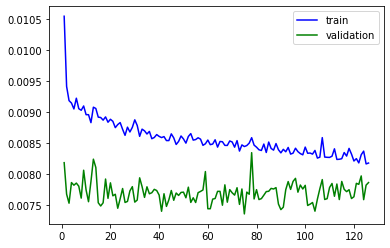

In [31]:
import matplotlib.pyplot as plt

epochs = np.arange(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, color='blue', label='train')
plt.plot(epochs, val_losses, color='green', label='validation')

plt.legend()
plt.show()

In [0]:
torch.save(milnet.state_dict(), root + '/models/milnet/base_rating_milnet_state_dict')
# milnet.load_state_dict(torch.load(root + '/models/milnet/rating_milnet_state_dict'))

In [0]:
test_loader = utils.data.DataLoader(test_set, batch_size=n_test,
                                     shuffle=True,
                                     collate_fn=prepare_batch,
                                     drop_last=True)

AMAZON = 'amazon'
ORGANIC = 'organic'
results = {}


milnet.eval()
with torch.set_grad_enabled(False):
  for documents, classes in test_loader:
    predictions = milnet(documents).cpu().numpy()
    results[AMAZON] = (np.argmax(predictions, axis=1), classes.cpu().numpy())
  
  predictions_organic = milnet(tuple(organic_embeddings.unsqueeze(1))).cpu().numpy()
  results[ORGANIC] = (np.argmax(predictions_organic, axis=1), 
                      organic_sentiments.cpu().numpy())

In [34]:
def print_results(name, top1, labels, class_labels=lambda x: x):
  print(f'=== {name} ===')
  print(f'F1-micro = {metrics.f1_score(labels, top1, average="micro")}')
  print(f'F1-macro = {metrics.f1_score(labels, top1, average="macro")}')
  confusion = metrics.confusion_matrix(labels, top1)
  sentiments = [class_labels(i) for i in range(len(confusion))]
  row_format ="{:>5}" * (len(confusion) + 1)
  print()
  print(row_format.format("", *sentiments))
  for sentiment, row in zip(sentiments, confusion):
    print(row_format.format(sentiment, *row))
  print()

for name, (top1, labels) in results.items():
  top1_sentiments = [sentiment_classes[get_sentiment(rating)]
                     for rating in top1]
  if name == AMAZON:
    print_results(name + ' for ratings', top1, labels)
    print()
    label_sentiments = [sentiment_classes[get_sentiment(rating)]
                        for rating in labels]
  else:
    label_sentiments = labels

  print_results(name + ' for sentiments', top1_sentiments, label_sentiments,
                lambda x: sentiment_labels[x])


=== amazon for ratings ===
F1-micro = 0.5941422594142259
F1-macro = 0.399465743127727

         0    1    2    3    4
    0   23    4   37    0    5
    1    1    5   49    0    9
    2    4    2  139    0   13
    3    1    0   21    0   16
    4    0    1   31    0  117


=== amazon for sentiments ===
F1-micro = 0.6380753138075314
F1-macro = 0.594987136595007

         n    0    p
    n   33   86   14
    0    6  139   13
    p    2   52  133

=== organic for sentiments ===
F1-micro = 0.46577498033044845
F1-macro = 0.4383552839511231

         n    0    p
    n  492  962   44
    0  302 1422  249
    p  192  967  454

